## Лабораторная работа 6.
### Сегментация текста

ФИО: Монастырный Максим Александрович

Группа: Б24-501 

**Импорт библиотек и константы**

In [1]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw, ImageFont

In [2]:
DATA_DIR = Path("../data/font")

CANVAS_PAD = 30
CROP_PAD = 2
THRESHOLD = 128

Вспомогательные функции

In [3]:
def binarize(img_l: Image.Image, threshold: int = THRESHOLD) -> np.ndarray:
    """Convert grayscale PIL image to boolean ink mask.

    Args:
      img_l: Grayscale image (mode 'L').
      threshold: Pixels darker than this are considered ink.

    Returns:
      Boolean numpy array of shape (H, W), True where ink.
    """
    img_l = img_l.convert("L")
    arr = np.asarray(img_l, dtype=np.uint8)
    return arr < threshold


def save_bmp(img_l: Image.Image, out_path: Path, threshold: int = THRESHOLD) -> None:
    """Save image as a 1-bit monochrome BMP."""
    img_l = img_l.convert("L")
    mono = img_l.point(lambda p: 255 if p > threshold else 0, mode="1")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    mono.save(out_path, format="BMP")


def save_profile_plot(
    values: np.ndarray, title: str, xlabel: str, ylabel: str, out_path: Path
) -> None:
    """Save a bar chart (PNG) for a 1D profile array."""
    n = int(values.shape[0])
    x = np.arange(n, dtype=np.int32)

    plt.figure()
    plt.bar(x, values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if n <= 40:
        plt.xticks(x)
    else:
        step = max(1, n // 20)
        plt.xticks(x[::step])

    ymax = int(values.max()) if n > 0 else 1
    yt_step = max(1, ymax // 10) if ymax > 0 else 1
    plt.yticks(np.arange(0, ymax + 1, yt_step))

    plt.tight_layout()
    plt.savefig(str(out_path), dpi=200)
    plt.close()

Класс Bounding Box

In [4]:
@dataclass(frozen=True)
class BBox:
    """Axis-aligned bounding box in pixel coordinates.

    Coordinates follow PIL convention:
      left, top inclusive; right, bottom exclusive.
    """

    left: int
    top: int
    right: int
    bottom: int

    @property
    def width(self) -> int:
        return max(0, self.right - self.left)

    @property
    def height(self) -> int:
        return max(0, self.bottom - self.top)

    @classmethod
    def from_image(cls, img: Image.Image, threshold: int = THRESHOLD) -> BBox | None:
        """Compute bounding box from image by binarizing with the given threshold.

        Returns None if image is empty.
        """
        mask = binarize(img, threshold=threshold)
        return cls.from_mask(mask)

    @classmethod
    def from_mask(cls, mask: np.ndarray) -> BBox | None:
        """Compute bounding box from boolean mask.

        Returns None if mask is empty.
        """
        rows = mask.any(axis=1)
        cols = mask.any(axis=0)
        if not rows.any() or not cols.any():
            return None

        top = int(np.argmax(rows))
        bottom = int(mask.shape[0] - np.argmax(rows[::-1]))
        left = int(np.argmax(cols))
        right = int(mask.shape[1] - np.argmax(cols[::-1]))

        return cls(left=left, top=top, right=right, bottom=bottom)

    def draw(self, img: Image.Image, color: str = "red", width: int = 1) -> Image.Image:
        """Draw the bounding box on the given image."""
        out = img.convert("RGB")
        draw = ImageDraw.Draw(out)
        for i in range(width):
            draw.rectangle(
                [self.left - i, self.top - i, self.right - 1 + i, self.bottom - 1 + i],
                outline=color,
            )

        return out

    def crop(self, img: Image.Image) -> Image.Image:
        """Crop the given image to this bounding box."""
        return img.crop((self.left, self.top, self.right, self.bottom))

Генерация текста

In [5]:
def load_font(font_name: str, size_pt: int) -> tuple[ImageFont.ImageFont, str]:
    """Load a TrueType/OpenType font by name with fallback.

    Args:
        font_name: Requested font family name.
        size_pt: Font size in points.

    Returns:
        (font_object, resolved_font_label)
    """
    path = fm.findfont(font_name, fallback_to_default=False)
    return ImageFont.truetype(path, size_pt), font_name


def render_symbol(
    ch: str,
    font: ImageFont.FreeTypeFont,
    padding: int = CROP_PAD,
    canvas_pad: int = CANVAS_PAD,
) -> Image.Image:
    """Render a single character to a tightly-cropped grayscale image."""
    if len(ch) != 1:
        raise ValueError("render_symbol expects a single character.")

    # Measure
    dummy = Image.new("L", (1, 1), color=255)
    draw = ImageDraw.Draw(dummy)
    bbox = draw.textbbox((0, 0), ch, font=font)
    w = max(1, bbox[2] - bbox[0])
    h = max(1, bbox[3] - bbox[1])

    canvas = Image.new("L", (w + 2 * canvas_pad, h + 2 * canvas_pad), color=255)
    draw = ImageDraw.Draw(canvas)
    draw.text((canvas_pad - bbox[0], canvas_pad - bbox[1]), ch, fill=0, font=font)

    arr = np.array(canvas, dtype=np.uint8)
    mask = arr < 250
    if not np.any(mask):
        return canvas

    ys, xs = np.where(mask)
    y0, y1 = int(ys.min()), int(ys.max())
    x0, x1 = int(xs.min()), int(xs.max())

    y0 = max(0, y0 - padding)
    x0 = max(0, x0 - padding)
    y1 = min(arr.shape[0] - 1, y1 + padding)
    x1 = min(arr.shape[1] - 1, x1 + padding)

    return canvas.crop((x0, y0, x1 + 1, y1 + 1))


def render_phrase_one_line(
    text: str,
    font: ImageFont.FreeTypeFont,
    letter_spacing: int = 1,
    word_spacing: int = 6,
    padding_y: int = CROP_PAD,
) -> Image.Image:
    """Render a phrase as a single-line image by composing per-char bitmaps.

    Uses per-character render + horizontal concatenation.
    """
    if not text:
        raise ValueError("Text is empty.")

    glyphs: list[Image.Image] = []
    spaces: list[int] = []
    for ch in text:
        if ch == " ":
            glyphs.append(None)
            spaces.append(word_spacing)
        else:
            glyphs.append(render_symbol(ch, font=font, padding=1))
            spaces.append(letter_spacing)

    heights = [g.height for g in glyphs if g is not None]
    if not heights:
        raise ValueError("Text contains only spaces.")
    line_h = max(heights) + 2 * padding_y

    widths = []
    for g, sp in zip(glyphs, spaces):
        if g is None:
            widths.append(sp)
        else:
            widths.append(g.width + sp)
    total_w = max(1, sum(widths))

    out = Image.new("L", (total_w, line_h), color=255)

    x = 0
    for g, sp in zip(glyphs, spaces):
        if g is None:
            x += sp
            continue
        y = (line_h - g.height) // 2
        out.paste(g, (x, y))
        x += g.width + sp

    ink = binarize(out, threshold=250)
    cols = ink.any(axis=0)
    if cols.any():
        left = int(np.argmax(cols))
        right = int(len(cols) - np.argmax(cols[::-1]))
        out = out.crop((left, 0, right, out.height))
    return out

In [6]:
def running_minimum_1d(x: np.ndarray, window: int) -> np.ndarray:
    """Running minimum with a symmetric window.

    This is the 'thinning' (прореживание) idea: valleys become more stable.

    Args:
      x: 1D int array.
      window: Odd window size (>=1).

    Returns:
      1D int array of same length.
    """
    if window <= 1:
        return x.copy()
    if window % 2 == 0:
        raise ValueError("window must be odd.")
    r = window // 2
    out = np.empty_like(x)
    n = x.shape[0]
    for i in range(n):
        a = max(0, i - r)
        b = min(n, i + r + 1)
        out[i] = np.min(x[a:b])
    return out


def nonzero_runs_1d(mask: np.ndarray) -> list[tuple[int, int]]:
    """Return [start, end) intervals where mask is True."""
    if mask.ndim != 1:
        raise ValueError("mask must be 1D.")
    if mask.size == 0:
        return []

    m = mask.astype(np.uint8)
    # Find edges: 0->1 and 1->0 transitions
    diff = np.diff(m, prepend=0, append=0)
    starts = np.where(diff == 1)[0]
    ends = np.where(diff == -1)[0]
    return [(int(s), int(e)) for s, e in zip(starts, ends)]

In [7]:
def segment_characters_one_line(
    img: Image.Image,
    threshold: int = THRESHOLD,
    valley_threshold: int = 0,
    thin_window: int = 1,
    min_width: int = 1,
    min_height: int = 2,
) -> list[BBox]:

    ink = binarize(img, threshold=threshold)

    line_bbox = BBox.from_mask(ink)
    if line_bbox is None:
        return []

    ink_line = ink[line_bbox.top : line_bbox.bottom, line_bbox.left : line_bbox.right]

    vprof = ink_line.sum(axis=0).astype(np.int32)
    vprof_thin = running_minimum_1d(vprof, window=thin_window)

    is_ink_col = vprof_thin > valley_threshold
    col_runs = nonzero_runs_1d(is_ink_col)

    boxes: list[BBox] = []
    for x0, x1 in col_runs:
        sub = ink_line[:, x0:x1]
        sub_bbox = BBox.from_mask(sub)
        if sub_bbox is None:
            continue

        bbox = BBox(
            left=line_bbox.left + x0 + sub_bbox.left,
            top=line_bbox.top + sub_bbox.top,
            right=line_bbox.left + x0 + sub_bbox.right,
            bottom=line_bbox.top + sub_bbox.bottom,
        )

        if bbox.width >= min_width and bbox.height >= min_height:
            boxes.append(bbox)

    boxes.sort(key=lambda b: b.left)
    return boxes

In [8]:
def build_symbol_profiles(
    alphabet: list[str],
    font: ImageFont.FreeTypeFont,
    threshold: int = THRESHOLD,
    normalize: bool = True,
) -> tuple[list[np.ndarray], list[np.ndarray]]:
    """Build horizontal and vertical profiles for each symbol in alphabet.

    Returns:
      h_profiles: shape (N, Hmax) padded with zeros
      v_profiles: shape (N, Wmax) padded with zeros
    """
    glyph_masks: list[np.ndarray] = []
    for ch in alphabet:
        g = render_symbol(ch, font=font)
        mask = binarize(g, threshold=threshold)
        bbox = BBox.from_mask(mask)
        if bbox is None:
            glyph_masks.append(np.zeros((1, 1), dtype=bool))
        else:
            # glyph_masks.append(mask[bbox.top : bbox.bottom, bbox.left : bbox.right])
            glyph_masks.append(mask)

    # Profiles
    h_list = [m.sum(axis=1).astype(np.int32) for m in glyph_masks]
    v_list = [m.sum(axis=0).astype(np.int32) for m in glyph_masks]

    h_profiles = []
    v_profiles = []

    for i, (h, v) in enumerate(zip(h_list, v_list)):
        hh = h.astype(np.float32)
        vv = v.astype(np.float32)
        if normalize:
            if hh.max() > 0:
                hh /= hh.max()
            if vv.max() > 0:
                vv /= vv.max()

        h_profiles.append(hh)
        v_profiles.append(vv)

    return h_profiles, v_profiles


def save_profiles(
    out_path: Path,
    alphabet: list[str],
    h_profiles: np.ndarray,
    v_profiles: np.ndarray,
) -> None:
    """Save profiles"""
    out_path.mkdir(parents=True, exist_ok=True)

    for symbol, h_prof, v_prof in zip(alphabet, h_profiles, v_profiles):
        save_profile_plot(
            v_prof,
            title=f"X-profile for '{symbol}'",
            xlabel="x (column index)",
            ylabel="black pixels",
            out_path=out_path / f"{ord(symbol):04X}_X.png",
        )
        save_profile_plot(
            h_prof,
            title=f"Y-profile for '{symbol}'",
            xlabel="y (row index from top)",
            ylabel="black pixels",
            out_path=out_path / f"{ord(symbol):04X}_Y.png",
        )

Необходимые параметры

In [9]:
GREEK_LOWER = list("αβγδεζηθικλμνξοπρστυφχψω")

# Такие из коробки есть в Ubuntu
# FONT_NAMES = [
#     "DejaVu Sans",
#     "Liberation Serif",
#     "Liberation Sans",
#     "Liberation Mono",
# ]
# SIZES_PT = [10, 11, 12, 14, 16]

In [10]:
# Love is all you need (через переводчик Google)
PHRASE = "Η αγάπη είναι το μόνο που χρειάζεσαι"
FONT = "DejaVu Sans"
FONT_SIZE = 16

Генерация строки

In [11]:
font, font_label = load_font(FONT, FONT_SIZE)
img_line = render_phrase_one_line(
    PHRASE, font, letter_spacing=0, word_spacing=10, padding_y=0
)

bmp_path = DATA_DIR / "phrase.bmp"
save_bmp(img_line, bmp_path)

In [12]:
Image.open(bmp_path)

Сегментация текста

In [13]:
img_in = Image.open(bmp_path)

In [14]:
bbox_all = BBox.from_image(img_in)
bbox_all.draw(img_in)

In [15]:
boxes = segment_characters_one_line(img_in)
len(boxes)

30

In [16]:
chars_dir = DATA_DIR / "chars"
chars_dir.mkdir(parents=True, exist_ok=True)
annotated_img = img_in

for i, box in enumerate(boxes):
    annotated_img = box.draw(annotated_img)
    ch_img = box.crop(img_in)
    # Сохраняю вырезанные символы
    ch_path = chars_dir / f"char_{i:02d}.png"
    ch_img.save(ch_path)

# Сохраняю аннотированное изображение
annot_path = DATA_DIR / "phrase_with_boxes.png"
annotated_img.save(annot_path)

In [17]:
Image.open(annot_path)

Сохраняем профили как графики (хотя то же самое мы делали в прошлой лабораторной работе)

In [18]:
profiles_dir = chars_dir / "profiles"
profiles_dir.mkdir(parents=True, exist_ok=True)

h_prof, v_prof = build_symbol_profiles(GREEK_LOWER, font, normalize=False)
save_profiles(profiles_dir, GREEK_LOWER, h_prof, v_prof)

len(h_prof), len(v_prof)

(24, 24)

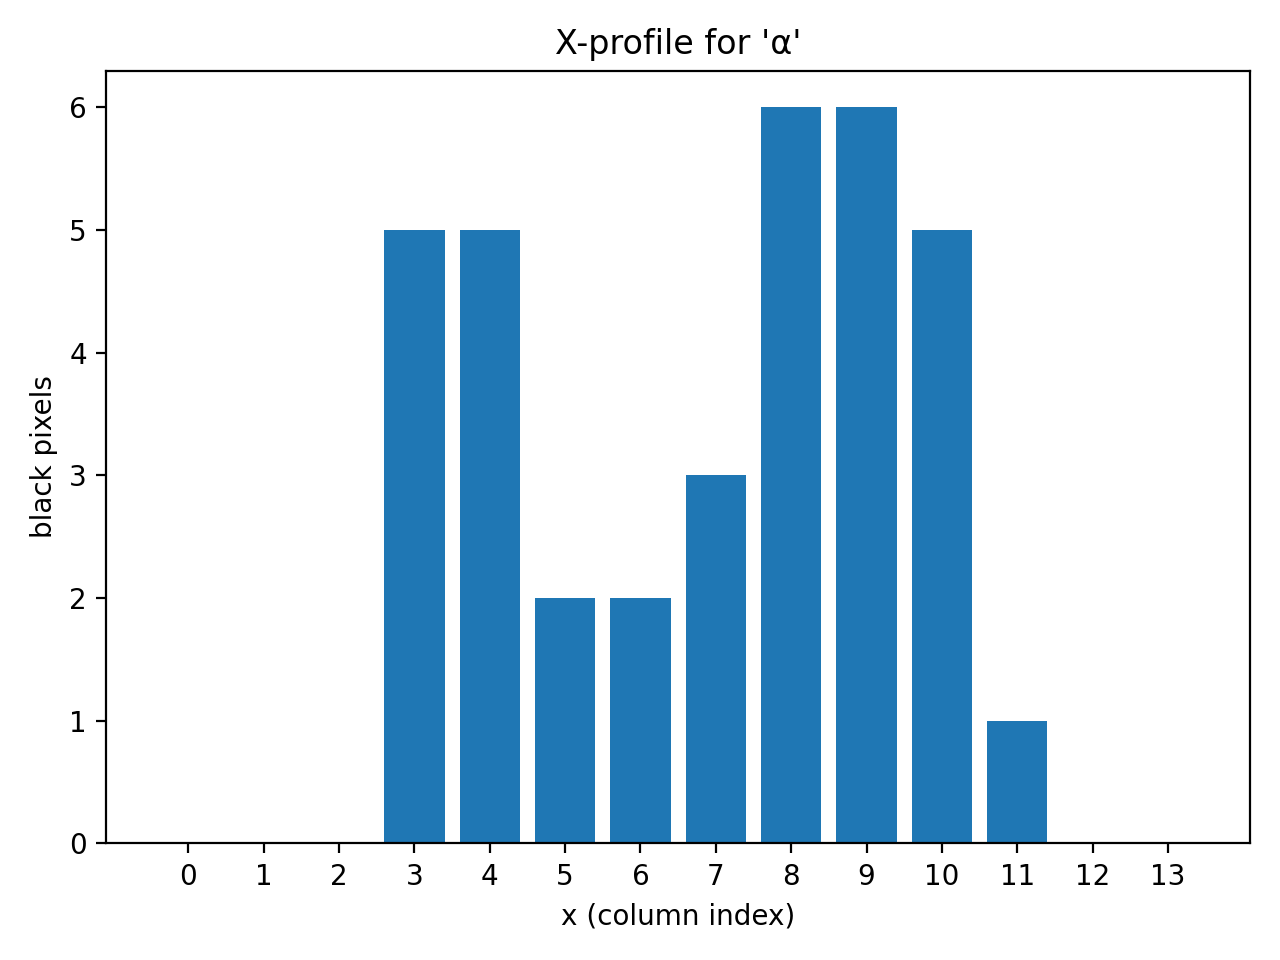

In [19]:
Image.open(profiles_dir / f"{ord(GREEK_LOWER[0]):04X}_X.png")

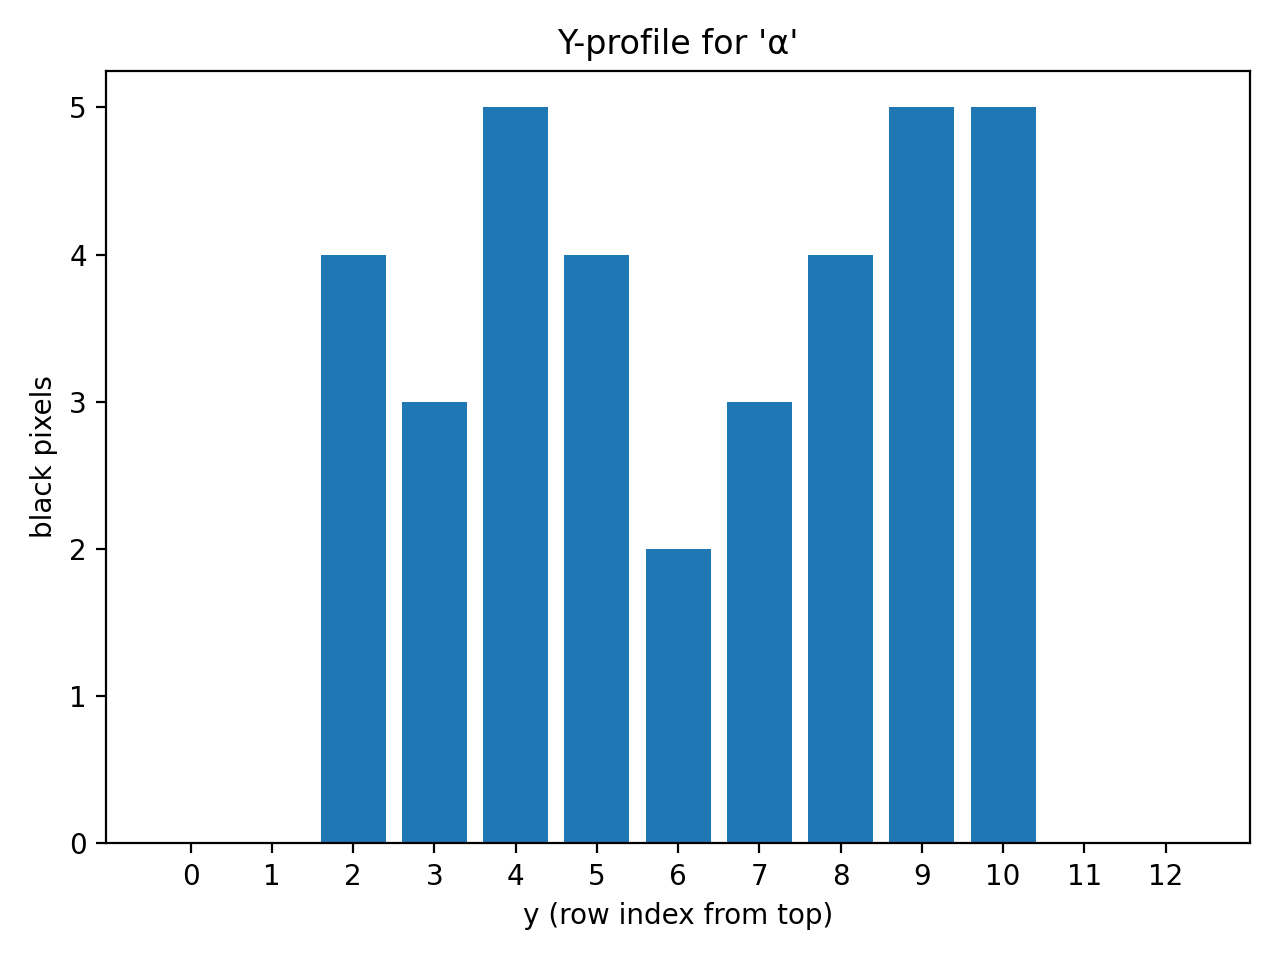

In [20]:
Image.open(profiles_dir / f"{ord(GREEK_LOWER[0]):04X}_Y.png")